<a href="https://colab.research.google.com/github/SantiagoBeltran/Proyecto-Caos/blob/main/Ruta_Caos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importación de paquetes en Python

In [1]:
from matplotlib.pyplot import *
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import *
from numpy import *
from scipy.integrate import odeint
from scipy import optimize

# Hamiltoniano del sistema
En las variables originales
$$H_i=\frac{1}{2}(p_x^2+p_y^2)+\frac{1}{2}(p_xy-p_yx)+2(x^2+y^2)+\frac{\alpha}{4}(\frac{3}{2}p_x-y)^4$$
En las variables transformadas
$$H=\frac{5}{4}(x^2+p_x^2)+\frac{3}{4}(y^2+p_y^2)+\frac{1}{4}(y^2+p_y^2)^2+\frac{\alpha}{4}(2x-y)^4$$
En las variables de ángulo-acción
$$H=\frac{5}{2}I_x+\frac{3}{2}I_y+I_y^2+\alpha(2\sqrt{I_x}\cos(\theta_x)-\sqrt{I_y}\cos(\theta_y))^4$$


# Secciones de Poincaré


> La generación de las secciones está basado en el trabajo de Lehmann L (https://stackoverflow.com/questions/48892663/poincare-section-of-a-system-of-second-order-odes).

> Las secciones estudiadas se tomaron a energía constante $E=10$. Acontinuaciónse definen las funciones de energía total y las ecuaciones de Euler-Lagrange en las variables transformadas $x$, $y$, $p_x$ y $p_y$,junto a una para $\alpha$ que se mantiene constante.





In [2]:
ener=10
def total_energy(x, y, px, py,alpha):
    return (5/4)*(x**2+px**2)+(3/4)*(y**2+py**2)+(1/4)*(y**2+py**2)**2+(alpha/4)*(2*x-y)**4

def pqdot(valpair, tval):
    # Retorno de las ecuaciones para las derivads temporales de x, y, px, py, y alpha
    (x, y, px, py, alpha) = tuple(valpair)
    return np.array([(5/2)*px,(3/2)*py+(y**2+py**2)*py,-(5/2)*x-2*alpha*(2*x-y)**3,-(3/2)*y-(y**2+py**2)*y+alpha*(2*x-y)**3,0]).T

Luego, se define la función cuyas entradas son la perturbación $\alpha$, un valor máximo para $\theta_{y_0}$, el número $n$ de valores de $\theta_{y_0}$, y un arreglo de las proporciones de $I_{y_{max}}$. Como resultado se retorna un arreglo de condiciones iniciales $(x,y,p_x,p_y, \alpha)$ para los distintos ángulos $\theta_y$ e $I_y$ que salistafacen $E=10$.

In [3]:
def inicial_cond(alpha, theta_max, n,prop, theta_min=0):
  # Condiciones de entrada
  c=[]
  x=0
  m=len(prop)
  thetay=np.linspace(theta_min,theta_max,n)

  # Cálculo de las condiciones iniciales
  for j in range(len(thetay)):
    solI = (-(3/2)+np.sqrt((3/2)**2+4*ener*((alpha)*np.cos(thetay[j])**4+1)))/(2*((alpha)*np.cos(thetay[j])**4+1))
    I=np.array(prop)*solI
    y0=np.sqrt(2*I)*np.cos(thetay[j])
    py0=np.sqrt(2*I)*np.sin(thetay[j])
    px0=np.zeros(len(y0))
    for i in range(len(y0)):
      px0[i]=np.sqrt((4/5)*(ener-((3/2)*I[i]+I[i]**2+(alpha)*I[i]**2*np.cos(thetay[j])**4)))
    for l in range(len(y0)):
      c.append([x,y0[l],px0[l],py0[l],alpha])
  return c 

Posteriormente se generaliza la función anterior para el cálculo de condiciones iniciales para cada uno de los valores de $\alpha$. Por esta razón los parámetros dde entrada son los mismos de la función anterior salvo que $\alpha$ es un arreglo de perturbaciones. Además, se retorna una lista de condiciones iniciales para cada uno de los valores de la perturbación.

In [4]:
def condiciones(alpha, theta_max, n,prop, theta_mn=0):
  # Construcción de arreglo de condiciones iniciales
  init_cons= []
  for k in range(len(alpha)):
    c=inicial_cond(alpha[k], theta_max, n,prop, theta_min=theta_mn)
    init_cons.append(c)
  return init_cons

También se define una función para los números de embobinado con el fin de mantener trazabilidad de los toros generados en caso integrable. Como entrada se tiene el valor máximo de $\theta_y$ y el número de valores iniciales de $\theta_y$ y se retorna un arreglo de números de enrollamiento del caso integrable para las condiciones iniciales.

In [5]:
def winding_number(theta_max, n, l2):
  # Condiciones iniciales
  alpha=0
  thetay=np.linspace(0,theta_max,n)
  wind=np.zeros(len(thetay)*l2)

  # Cálculo de los números de embobinado para el caso integrable
  for j in range(len(thetay)):
    solI = (-(3/2)+np.sqrt((3/2)**2+4*ener*((alpha)*np.cos(thetay[j])**4+1)))/(2*((alpha)*np.cos(thetay[j])**4+1))
    I=np.array(prop)*solI
    for k in range(len(I)):
      wind[len(I)*j+k]=((3/2+2*I[k])/(5/2))
  return wind

Se define, adicionalmente, una función encargada de la solución de las ecuaciones diferenciales de pqdot, como entrdas se ingresan la lista completa de condiciones iniciales y un arreglo de tiempo y se retornan vectores $(x,y, p_x,p_y, \alpha)$ para cada uno de los tiempos estudiados.

In [6]:
def evolucion(init_cons,t):
  # Solución de las ecuaciones diferenciales
  outs=[]
  for l in range(len(init_cons)):
    salida= [ odeint(pqdot, con, t, atol=1e-9, rtol=1e-8)  for con in init_cons[l][:len(init_cons[0])] ]
    outs.append(salida)
    print("Se han calculado {} perturbaciones de {}.".format(l+1,len(init_cons)))
  return outs 

A continuación se define una función que se encarga de encontrar y retornar los índices de los cortes de las secciones de Poincaré. sus entradas se espera que sean las salidas en el tiempo de $x$ (data) y de $p_x$ (data1).

In [7]:
def findcrossings(data, data1):
    # Halla los índices en los que ocurre un cambio de signo para x y px>0
    prb = list()
    for ii in range(len(data)-1):
        if (((data[ii] > 0) and (data[ii+1] < 0)) or ((data[ii] < 0) and (data[ii+1] > 0))) and data1[ii] > 0:
            prb.append(ii)
    return array(prb)

Luego, se define la función que halla los cortes en las variables $y, p_y$.  Para ello se tienen como entradas el conjunto de valores evolucionados de $(x,y,p_x,p_y,\alpha)$ (outs) y el vector de perturbaciones $\alpha$.


In [8]:
def hallar_Cortes(outs,alpha):
  # Cálculo de y y py para los cortes
  cortes=[]
  for l in range(len(outs)):
    calpha=[]
    for ii in range(len(outs[0])):
        xcrossings = findcrossings(outs[l][ii][:,0], outs[l][ii][:,2])
        yints = [.5*(outs[l][ii][cross, 1] + outs[l][ii][cross+1, 1]) for cross in xcrossings]
        pyints = [.5*(outs[l][ii][cross, 3] + outs[l][ii][cross+1, 3]) for cross in xcrossings]
        calpha.append([yints,pyints])
    cortes.append(calpha)
  return cortes 

En primer lugar se graficaron las secciones de Poincaré para unos determinados valores de números de embobinado en el hamiltoniano integrable, para unos ciertos valores de $\alpha$ que dejan en evidencia la ruptura de sus toros. Acontinuación se presentan los datos de entrada:

In [9]:
# Valores de la perturbación deseados 
alpha=np.array([0,0.0002,0.0008,0.002,0.0062,0.014,0.02,0.03,0.064])
print("Se consideraron las perturbaciones {}.".format(alpha))

# Proporción de Iy máximo deseados 
prop =np.array([0,1/5,3/10,np.pi/6,sqrt(2)/2,3/(2*(sqrt(5)-1))-3/10])
l2=len(prop)
print("Y se consideraron las proporciones={} de ".format(prop) + r"Iy máximo")

# Paso temporal 
t = linspace(0, 1000.0, 100000+1)
print("Se tomó un paso temporal de {} hasta t={}".format(t[1]-t[0],1000))

# Condiciones para thetay
l1=4
theta_max=2*np.pi


Se consideraron las perturbaciones [0.     0.0002 0.0008 0.002  0.0062 0.014  0.02   0.03   0.064 ].
Y se consideraron las proporciones=[0.         0.2        0.3        0.52359878 0.70710678 0.91352549] de Iy máximo
Se tomó un paso temporal de 0.01 hasta t=1000


Luego se realiza el cálculo de condiciones iniciales (init_cons), los números de embobinado (winding) y la evolución de las condiciones iniciales (outs):


In [10]:
# Construcción de las condiciones iniciales
init_cons=condiciones(alpha, theta_max, l1,prop)

# Cálculo de los números de embobinado
winding=winding_number(theta_max, l1, l2) 

# Evolución de las condiciones iniciales
outs=evolucion(init_cons,t)

Se han calculado 1 perturbaciones de 9.
Se han calculado 2 perturbaciones de 9.
Se han calculado 3 perturbaciones de 9.
Se han calculado 4 perturbaciones de 9.
Se han calculado 5 perturbaciones de 9.
Se han calculado 6 perturbaciones de 9.
Se han calculado 7 perturbaciones de 9.
Se han calculado 8 perturbaciones de 9.
Se han calculado 9 perturbaciones de 9.


Luego se hallan los cortes de la sección de Poincaré:

In [11]:
# Cálculos de los cortes en las secciones
cortes=hallar_Cortes(outs,alpha)

Gráficas a color de las distintas secciones de Poinacré para las perturbaciones iniciales con convenciones para los números de embobinado.

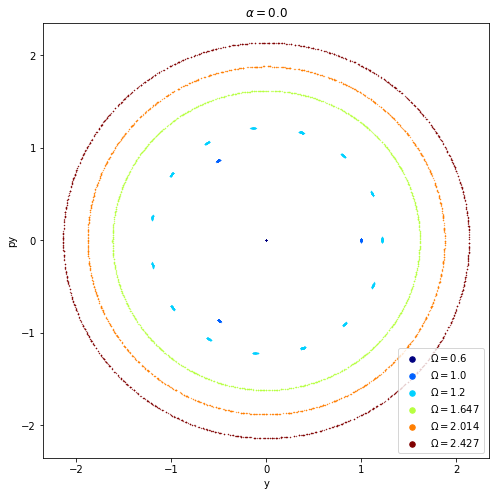

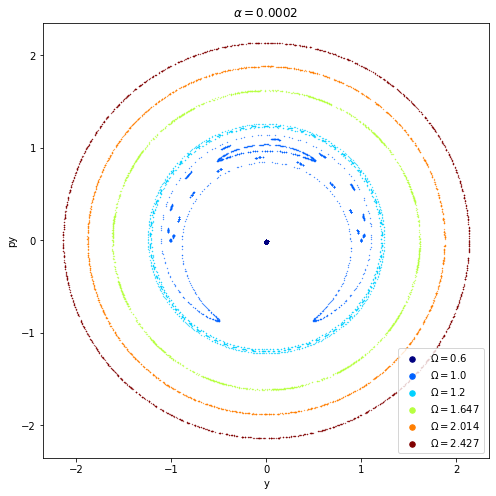

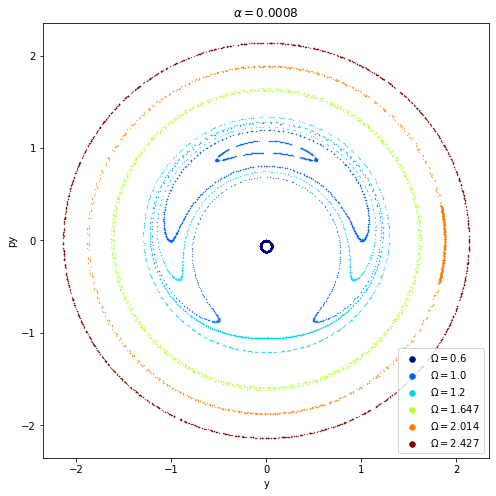

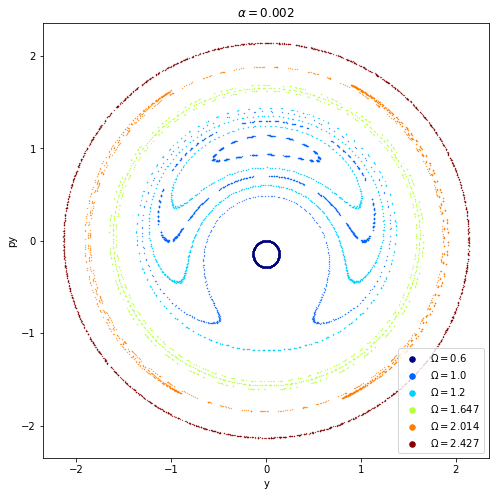

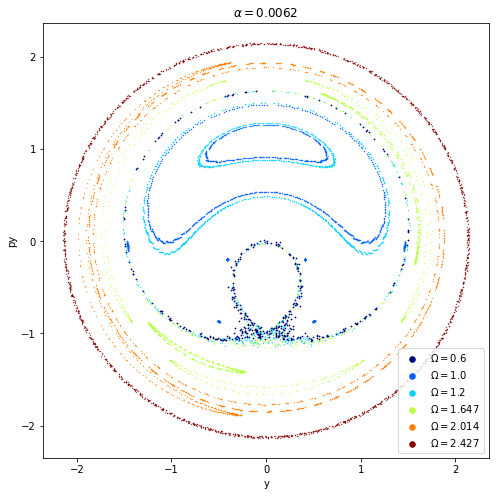

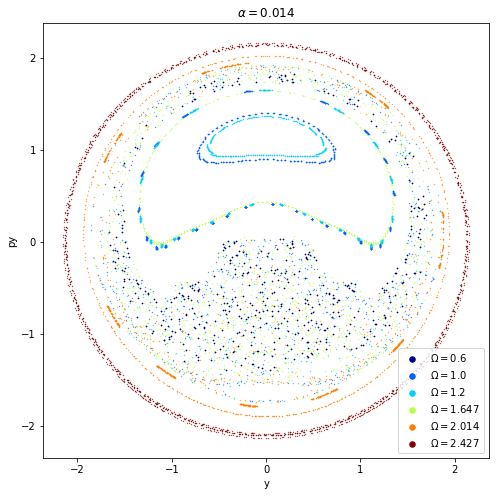

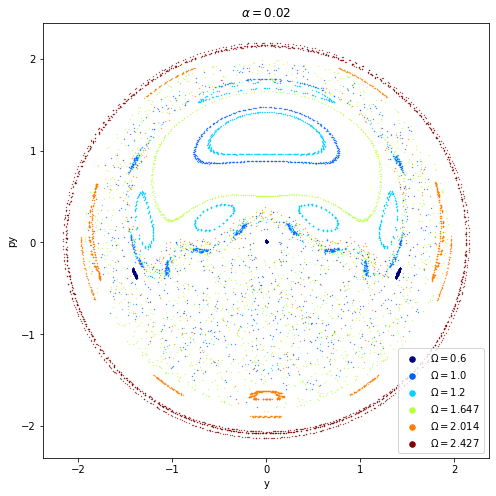

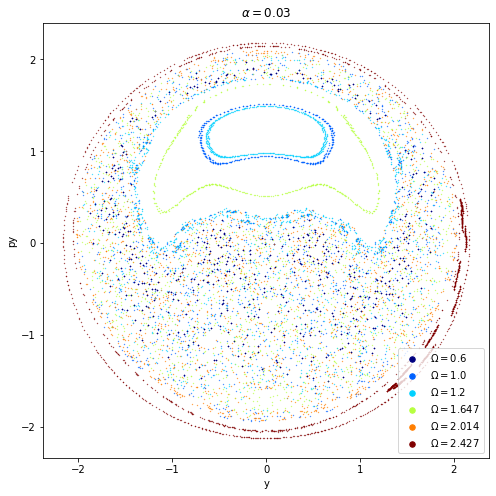

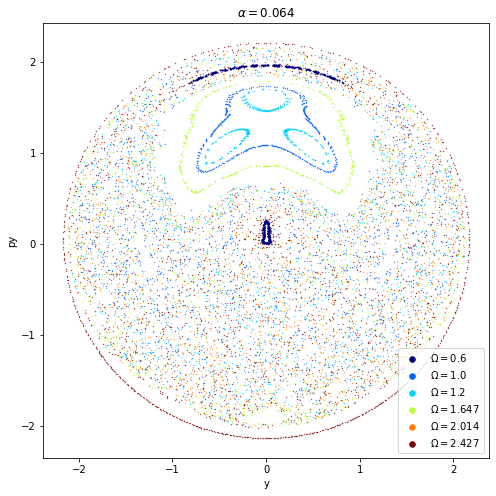

In [12]:
#Se fijan los colores para cada número de embobinado
norm = mpl.colors.Normalize(vmin=winding.min(), vmax=winding.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.jet)
cmap.set_array([])

#Graficación una a una de las secciones de Poinacré elegidas
for l in range(len(alpha)):
  fig2 = figure(2, figsize=(8,8))
  for ii in range(len(outs[0])):
    col=cmap.to_rgba(winding)[ii]
    if ii<l2:
      scatter(np.array(cortes[l][ii][0]), np.array(cortes[l][ii][1]), s=0.1,color=col, label=r"$\Omega={}$".format(np.round(winding[ii],3)))
    else:
      scatter(np.array(cortes[l][ii][0]), np.array(cortes[l][ii][1]), s=0.1,color=col)
  title(r"$\alpha={}$".format(np.round(alpha[l],4)))
  ylabel("py")
  xlabel("y") 
  lgnd = legend(loc="lower right", scatterpoints=1, fontsize=10)
  for i in range(l2):
    lgnd.legendHandles[i]._sizes = [30]
  plt.savefig("seccion_Poincare_winding_{}.png".format(np.round(alpha[l],4)))
  plt.show()

Cálculo de las fracciones continuadas: Se define una primera función para el cálculo de los términos de fracciones continuadas que se le atribuye a Piotrowski A. recuperada de https://www.bookofproofs.org/branches/continued-fraction-python/ ; y una función que se encarga de deeterminar el error respecto al número generado por Python 

In [13]:
# Función encargada de hallar los factores de fracciones continuadas
def contFrac(x, k):
    cf = []
    q = math.floor(x)
    cf.append(q)
    x = x - q
    i = 0
    while x != 0 and i < k:
        q = math.floor(1 / x)
        cf.append(q)
        x = 1 / x - q
        i = i + 1
    return cf

# Función que calcula las diferencias con los números generados por Python
def frac_approx(x,k):
  coef=contFrac(x,k)
  if len(coef)==1:
    return coef[0]
  i=-2
  a=1/coef[-1]
  while i>-len(coef):
    a=1/(coef[i]+a)
    i=i-1
  return a+coef[0]    


Implementación para los números de embobinado estudiados

In [14]:
# Números de embobinado analizados
wind=[0.6,1,6/5,8/5, 3/5+(2/5)*np.pi, 3/5+sqrt(2),3/(sqrt(5)-1)]

# Implementación
for w in winding[:6]:
  print("Términos necesarios para que los winding numbers tengan un error de cero computacional")
  j=1
  x=10
  while x!=0:
    x=abs(frac_approx(w,j)-w)
    j=j+1
  print("La sequencia para {} es: {}. Tiene {} términos".format(round(w,3), contFrac(w,j-1), len(contFrac(w,j-1))))  

Términos necesarios para que los winding numbers tengan un error de cero computacional
La sequencia para 0.6 es: [0, 1, 1, 2, 1125899906842624]. Tiene 5 términos
Términos necesarios para que los winding numbers tengan un error de cero computacional
La sequencia para 1.0 es: [1]. Tiene 1 términos
Términos necesarios para que los winding numbers tengan un error de cero computacional
La sequencia para 1.2 es: [1, 5]. Tiene 2 términos
Términos necesarios para que los winding numbers tengan un error de cero computacional
La sequencia para 1.647 es: [1, 1, 1, 1, 5, 24, 1, 3, 3, 1, 1, 1, 22, 7, 4, 1, 6]. Tiene 17 términos
Términos necesarios para que los winding numbers tengan un error de cero computacional
La sequencia para 2.014 es: [2, 70, 2, 1, 4, 2, 1, 1, 1, 1, 2, 4, 1, 2, 70]. Tiene 15 términos
Términos necesarios para que los winding numbers tengan un error de cero computacional
La sequencia para 2.427 es: [2, 2, 2, 1, 12, 1, 2, 2, 2, 1, 12, 1, 2, 2, 2, 1, 12, 1, 2]. Tiene 19 términos


Nueva implementación para algunas secciones de Poincaré de interés para un espectro más amplio de proporciones de $I_{y_{max}}$. A continuación se presentan los datos de las perturbaciones:


In [15]:
# Valores de la perturbación deseados 
alpha=np.array([0.0212,0.0680,0.0753,0.0788,0.0950])
print("Se consideraron las perturbaciones {}.".format(alpha))

# Proporción de Iy máximo deseados
prop =np.linspace(0,0.999,15)
l2=len(prop)
print("Y se consideraron las proporciones={} de ".format(prop) + r"Iy máximo")

# Paso temporal 
t = linspace(0, 1000.0, 100000+1)
print("Se tomó un paso temporal de {} hasta t={}".format(t[1]-t[0],1000))

# Condiciones para thetay
l1=4
theta_max=2*np.pi

Se consideraron las perturbaciones [0.0212 0.068  0.0753 0.0788 0.095 ].
Y se consideraron las proporciones=[0.         0.07135714 0.14271429 0.21407143 0.28542857 0.35678571
 0.42814286 0.4995     0.57085714 0.64221429 0.71357143 0.78492857
 0.85628571 0.92764286 0.999     ] de Iy máximo
Se tomó un paso temporal de 0.01 hasta t=1000


Luego se realiza el cálculo de condiciones iniciales (init_cons), los números de embobinado (winding) y la evolución de las condiciones iniciales (outs):

In [16]:
# Construcción de las condiciones iniciales
init_cons=condiciones(alpha, theta_max, l1,prop)

# Cálculo de los números de embobinado
winding=winding_number(theta_max, l1, l2) 

# Evolución de las condiciones iniciales
outs=evolucion(init_cons,t)

Se han calculado 1 perturbaciones de 5.
Se han calculado 2 perturbaciones de 5.
Se han calculado 3 perturbaciones de 5.
Se han calculado 4 perturbaciones de 5.
Se han calculado 5 perturbaciones de 5.


Luego se hallan los cortes de la sección de Poincaré:

In [17]:
# Cálculos de los cortes en las secciones
cortes=hallar_Cortes(outs,alpha)

Gráficas a blanco y negro de las distintas secciones de Poincaré para las perturbaciones de interés.

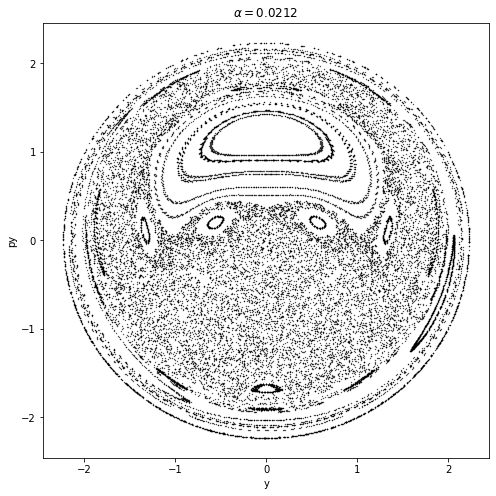

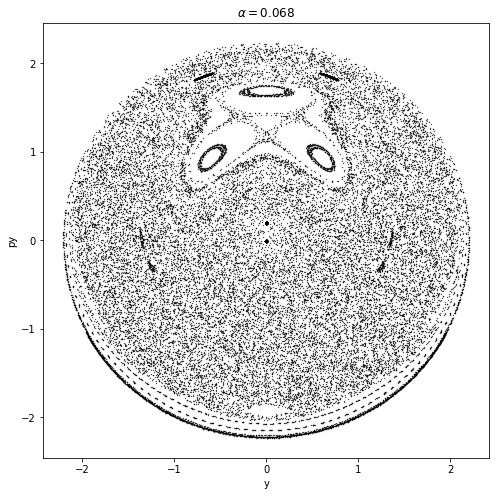

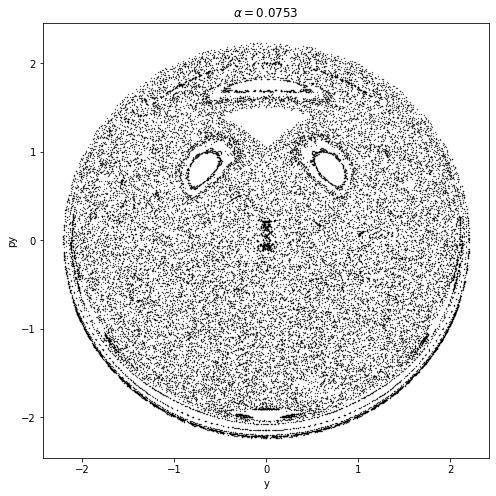

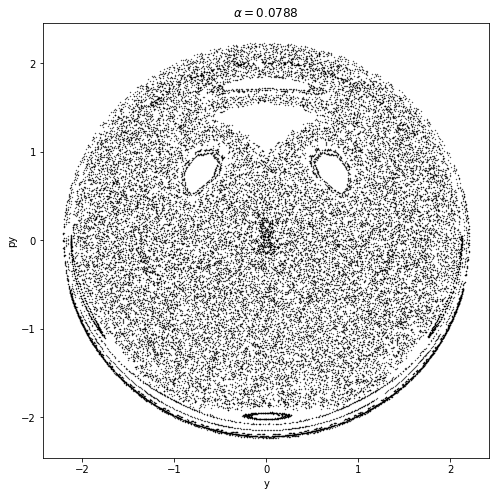

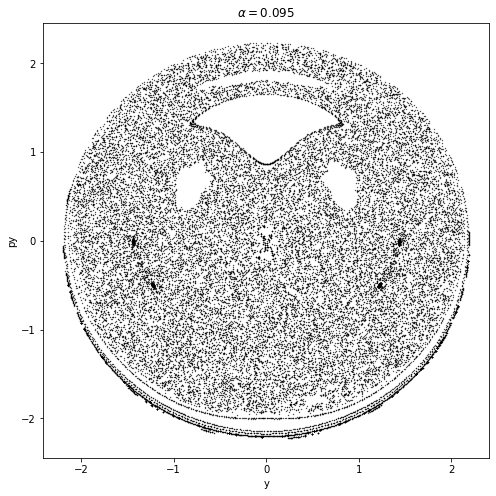

In [18]:
# Graficación de las distintas secciones para las nuevas perturbaciones
for l in range(len(outs)):
  fig2 = figure(2, figsize=(8,8))
  for ii in range(len(outs[0])):
    scatter(np.array(cortes[l][ii][0]), np.array(cortes[l][ii][1]), s=0.1,color="black")
  title(r"$\alpha={}$".format(np.round(alpha[l],4)))
  ylabel("py")
  xlabel("y") 
  plt.savefig("seccion_Poincare_bn_{}.png".format(np.round(alpha[l],4)))
  plt.show()

Gráfica en acercamiento para la sección de Poincaré para $\alpha=0.0212$ y selección cualitativa de l regiones hiperbólicas en rojo.

0.0212


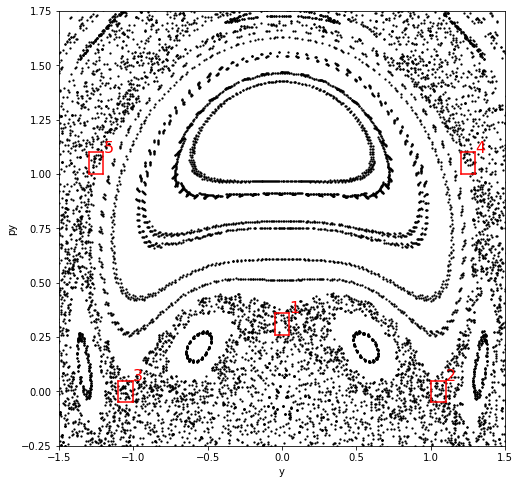

In [19]:
# Elección de la sección a acercar y la ubicación cualitativa de las regiones hiperbólicas
l=-0
py_fixl=[0.31,0,0,1.05,1.05]
y_fixl=[0,1.05,-1.05,1.25,-1.25]

# Graficación del scatter de cortes para la sección
fig2 = figure(2, figsize=(8,8))
for ii in range(len(outs[0])):
  scatter(np.array(cortes[l][ii][0]), np.array(cortes[l][ii][1]), s=1.5,color="black")

# Graficación de las regiones hiperbólicas
for j in range(len(y_fixl)):
  y_fix=y_fixl[j]
  py_fix=py_fixl[j]
  plt.text(y_fix+0.05,py_fix+0.05,"{}".format(j+1), color="red", fontsize=16 )
  d=0.05
  plt.plot(np.linspace(y_fix-d,y_fix+d,20), np.ones(20)*(py_fix+d), color="red")
  plt.plot(np.linspace(y_fix-d,y_fix+d,20), np.ones(20)*(py_fix-d), color="red")
  plt.plot(np.ones(20)*(y_fix-d),np.linspace(py_fix-d,py_fix+d,20),  color="red")
  plt.plot( np.ones(20)*(y_fix+d), np.linspace(py_fix-d,py_fix+d,20), color="red")
xlim(-1.5,1.5)
ylim(-0.25,1.75) 
ylabel("py")
xlabel("y") 
print(alpha[l])
plt.savefig("seccion_Poincare_zoom_{}.png".format(np.round(alpha[l],4)))
plt.show()

Gráfica en acercamiento para las secciones de Poincaré para $\alpha=0.0680$ y $\alpha=0.0753$ para la ubicación de los toros.

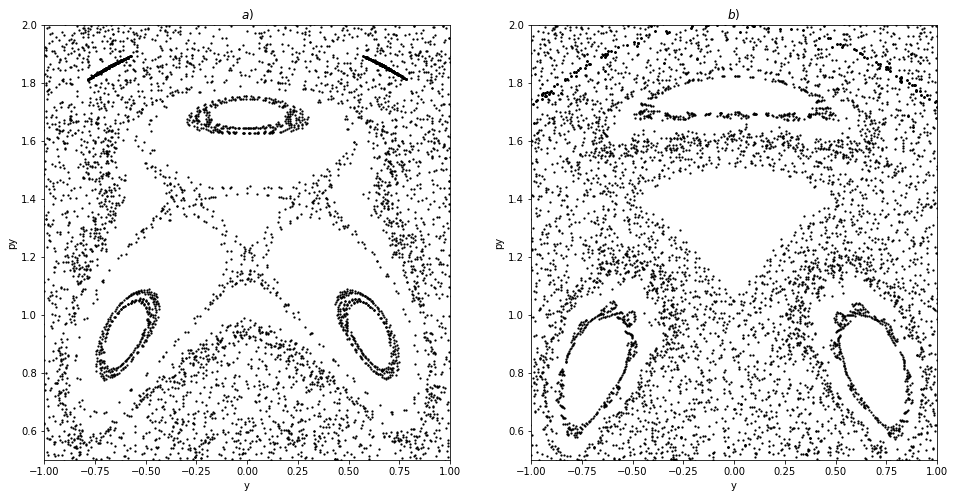

In [20]:
# Creación de la figura
fig2 = figure(2, figsize=(16,8))

# Graficación del acercamiento para 0.0680
subplot(1,2,1)
l=1
for ii in range(len(outs[0])):
  scatter(np.array(cortes[l][ii][0]), np.array(cortes[l][ii][1]), s=1.5,color="black")
title(r"$a)$")
xlim(-1,1)
ylim(0.5,2) 
ylabel("py")
xlabel("y") 

# Graficación del acercamiento para 0.0753
subplot(1,2,2)
l=2
for ii in range(len(outs[0])):
  scatter(np.array(cortes[l][ii][0]), np.array(cortes[l][ii][1]), s=1.5,color="black")
title(r"$b)$")
xlim(-1,1)
ylim(0.5,2) 
ylabel("py")
xlabel("y") 

plt.savefig("seccion_Poincare_fractal.png")
plt.show()

Gráfica en acercamiento para la sección de Poincaré para $\alpha=0.0788$ para la ubicación de los toros.

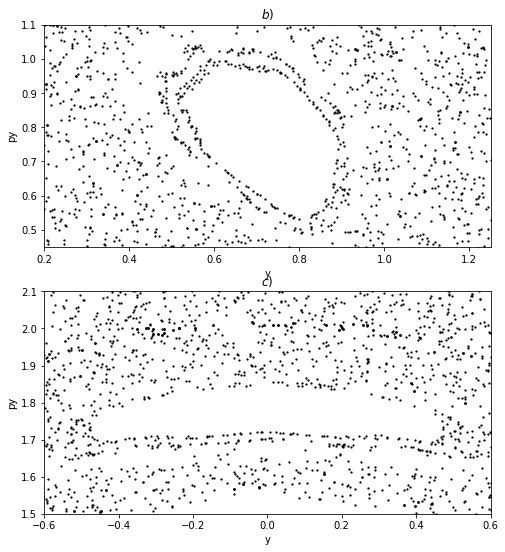

In [21]:
# Creación de la figura
fig2 = figure(2, figsize=(8,9))

# Graficación del primer toro
l=3
subplot(2,1,1)
for ii in range(len(outs[0])):
  scatter(np.array(cortes[l][ii][0]), np.array(cortes[l][ii][1]), s=1.5,color="black")
title(r"$b)$")
xlim(0.2,1.25)
ylim(0.45,1.1) 
ylabel("py")
xlabel("y") 

# Graficación del segundo toro
subplot(2,1,2)
for ii in range(len(outs[0])):
  scatter(np.array(cortes[l][ii][0]), np.array(cortes[l][ii][1]), s=1.5,color="black")
title(r"$c)$")
xlim(-0.6,0.6)
ylim(1.5,2.1) 
ylabel("py")
xlabel("y") 
plt.savefig("seccion_Poincare_zoom_{}.png".format(np.round(alpha[l],4)))
plt.show()

# Nudo homoclínico


> Se revisó el comportamiento de los puntos en la región 1 hiperbólica de la sección para $\alpha$=0.0212.


> Se define la función nudo_homoclinico que toma un valor de $\alpha$ y la ubicación aproximada de un punto fijo hiperbólico y halla los cortes de la sección de Poinacré correspondientes a condiciones iniciales generadas en una región cuadrada de lado 0.10 en la vecidad del punto fijo ingresado. 


In [22]:
def nudo_homoclinico(alpha, yfijo, pyfijo, tmax):

  # Condiciones
  t = arange(0, tmax, 0.01)
  a=np.array([alpha])
  n=100
  ener=10

  # Cálculo de condiciones iniciales
  y=np.random.rand(n)*0.01-0.005+yfijo
  py=np.random.rand(n)*0.01-0.005+pyfijo
  px=np.sqrt((4/5)*(ener-(3/4)*(y**2+py**2)-(1/4)*(y**2+py**2)**2-(alpha/4)*y**4))
  init_cons=[]
  for l in range(len(y)):
      init_cons.append([0,y[l],px[l],py[l],alpha])

  # Evolución de la trayectoria    
  outs= [ odeint(pqdot, con, t, atol=1e-9, rtol=1e-8)  for con in init_cons[:len(init_cons)] ]

  # Cálculo de cortes
  calpha=[]
  for ii in range(len(outs)):
      xcrossings = findcrossings(outs[ii][:,0], outs[ii][:,2])
      yints = [.5*(outs[ii][cross, 1] + outs[ii][cross+1, 1]) for cross in xcrossings]
      pyints = [.5*(outs[ii][cross, 3] + outs[ii][cross+1, 3]) for cross in xcrossings]
      calpha.append([yints,pyints])
  return calpha

Condiciones del punto fijo hiperbólico analizado, donde $a$ es el valor de $\alpha$, y $y_{fix},p_{y_{fix}}$ es la ubicación tentativa del punto fijo.

In [23]:
#Condiciones y cálculo del corte
a=0.0212
py_fix=0.31
y_fix=0
cortes0=(nudo_homoclinico(a, y_fix, py_fix, 500))

#Cálculo del índice máximo para los cortes
max=0
for j in range(len(cortes0)):
  new_max=len(cortes0[j][0])
  if new_max>max:
    max=new_max
index=np.linspace(0,max-1,max)  

El punto fijo hiperbólico es cercano a y=-0.09711520109695268 y py=0.3841235269014251
En este acercamiento el putno fijo depende de la aleatoriedad de las condciones iniciales
Número de puntos en cada cruce:[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 36.  0.  0.  0.  0.  5.
  0.  0. 10.  0.  0.  4.  0.  4.  0.  0.  8.  7.  1.  5.  0.  1.  3.  0.
  9. 13.  3.  3.  0.  2.  3.  0.  4. 12.  2.  3.  0.  1.  3.  0.  1.  1.
  2.  2.  0.  2.  6.  0.  0.  1.  4.  5.  0.  1.  1.  2.  2.  0.  5.  2.
  0.  2.  3.  3.  2.  1.  3.  2.  3.  1.  7.  5.  2.  2.  1.  0.  0.  1.
  1.  3.  1.  1.  1.  4.  1.  2.  0.  2.  4.  1.  1.  3.  1.  2.  0.  3.
  0.  1.  2.  0.  3.  1.  1.  1.  0.  0.  2.  1.  1.  0.  0.  1.  0.  3.
  0.  1.  2.  1.  4.  2.  2.  0.  0.  1.  2.  5.  4.  1.  3.  0.  0.  1.
  3.  3.  3.  2.  2.  1.  2.  1.  1.  3.  1.  1.  0.  1.  2.  1.  1.  1.
  1.  3.  0.  1.  2.  2.  1.  0.  0.  1.  0.  0.  3.  3.  1.  2.  1.  0.
  3.  2.  2.  0.  1.  2.  1.  1.  0.  0.  1.  0.  0.  1.  0.  2

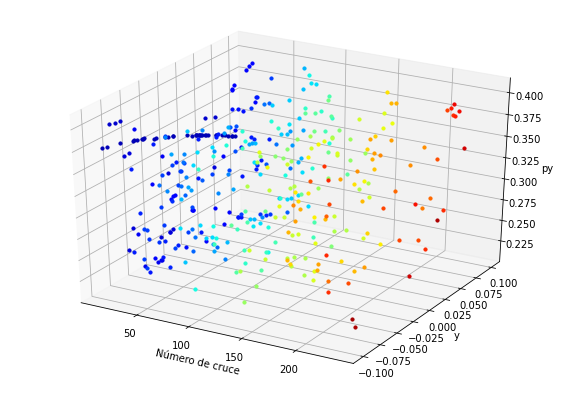

In [24]:
# Creación de la figura y fijación de los colores
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
norm = mpl.colors.Normalize(vmin=index.min(), vmax=index.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.jet)
cmap.set_array([])

# Cálculo aproximado del punto fijo hiperbólico
yfinal=0
pyfinal=0
cantidad=np.zeros(max)

# Representación 3D de los cortes 
for ii in range(len(cortes0)):
  for k in range(len(cortes0[ii][0])):
    ypoint=cortes0[ii][0][k]
    pypoint=cortes0[ii][1][k]
    if ypoint>y_fix-0.1 and ypoint<y_fix+0.1 and pypoint>py_fix-0.1 and pypoint<py_fix+0.1:
      cantidad[k]=cantidad[k]+1
      col=cmap.to_rgba(index)[k]
      yfinal=ypoint
      pyfinal=pypoint
      ax.scatter3D(k,ypoint, pypoint, s=10,color=col)
ax.set_xlabel("Número de cruce")
ax.set_ylabel("y")
ax.set_zlabel("py")
print("El punto fijo hiperbólico es cercano a y={} y py={}".format(yfinal,pyfinal))
print("En este acercamiento el putno fijo depende de la aleatoriedad de las condciones iniciales")
print("Número de puntos en cada cruce:{}".format(cantidad))
plt.savefig("nudo_homoclinico3d_{}.png".format(np.round(a,4)))
plt.show()

#Coeficientes de Lyapunov


> Definición de la función lyapunov que retorna el número de aplicación del mapa $T$ y el logaritmo de la distancia $\log(\delta y)$ entre dos trayectorias inicialmente contiguas a $\delta y_0=1.0\times 10^{-5}$ para $\alpha=0.095$ y una condición inicial indexada por $w$
 en la región caótica.


In [25]:
def lyapunov(alpha, delta0,w):
  # Parámetros
  t = arange(0, 100.0, 0.1)
  a=np.array([alpha])
  l1=2
  l2=6
  prop=np.linspace(0,0.9999,l2)

  # Condicioens iniciales
  init=condiciones(a,delta0,l1,prop)
  I1=0.5*(init[0][w][1]**2+init[0][w][3]**2)
  I2=0.5*(init[0][w+l2][1]**2+init[0][w][3]**2)
  print("La diferencia inicial es {}".format(abs(init[0][w][1]-init[0][w+l2][1])))

  # Evolución temporal y cortes
  out=evolucion(init,t)
  cortes0=hallar_Cortes(out,a)

  # Cálculo de diferencias entre trayectorias adyacentes
  m=min(len(cortes0[0][w+l2][0]),len(cortes0[0][w][0]))
  logdy=log(abs(np.array(cortes0[0][w+l2][0][:m])-np.array(cortes0[0][w][0][:m])))
  N=np.linspace(0,len(logdy)-1,len(logdy))
  return N,logdy

Implementación para $\alpha=0.095$.


In [26]:
# Cálculo de los pares ordenados
N,logdy=lyapunov(0.0950,1E-5,2)  

La diferencia inicial es 6.478106939766803e-11
Se han calculado 1 perturbaciones de 1.


Se obtuvo una pendiente de 0.11373502227822829, con punto de corte en -12.173808288266576 y matriz de covarianza [[ 6.96886408e-05 -1.70737168e-03]
 [-1.70737168e-03  5.63432652e-02]]


<Figure size 576x576 with 0 Axes>

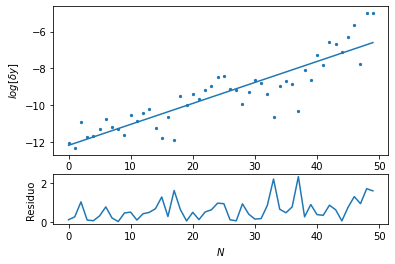

In [27]:
# Creación de la figura
figure(figsize=(8,8))
f,(a0,a1)=plt.subplots(2,1,gridspec_kw={'height_ratios':[3,1]})

# Graficación del primer subplot
a0.scatter(N[:50], logdy[:50], s=5)
# Linealización
def test_func(x, a, b):
    return a*x+b    
params, params_covariance = optimize.curve_fit(test_func, N[:50], logdy[:50],p0=[2, 2])
a0.plot(N[:50], test_func(N[:50], params[0], params[1]))
a0.set_ylabel(r"$log[\delta y]$")

#Graficación del segundo subplot
a1.plot(N[:50], abs(logdy[:50]-test_func(N[:50], params[0], params[1])))
a1.set_ylabel("Residuo")
a1.set_xlabel(r"$N$")
f.savefig("coeficientes_lyapunov.png")

print("Se obtuvo una pendiente de {}, con punto de corte en {} y matriz de covarianza {}".format(params[0], params[1], params_covariance))